# Kodak ColorPlus 200 v2

Notebook for extracting film pigment and experimenting with layers to get the right balancing.

## Film Pigment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

### Load film image & preprocess

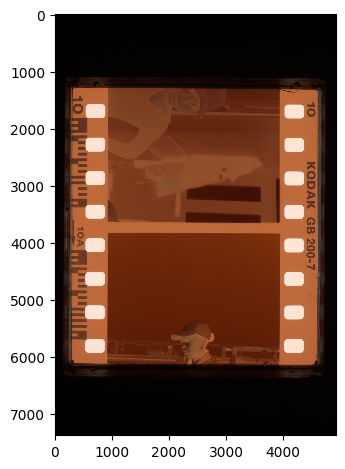

In [2]:
import rawpy

with rawpy.imread("Films/raw/COLOR_PLUS_200.NEF") as raw:
    image = ski.util.img_as_float32(raw.postprocess().copy())

ski.io.imshow(image)

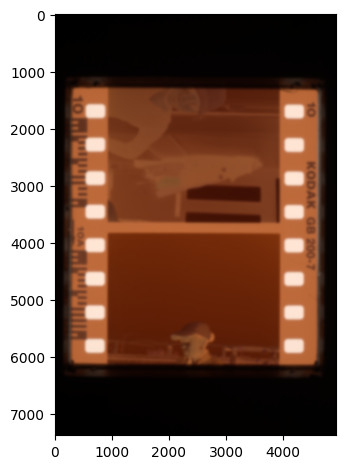

In [3]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [4]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [5]:
LIMIT_COLOURS = 50

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

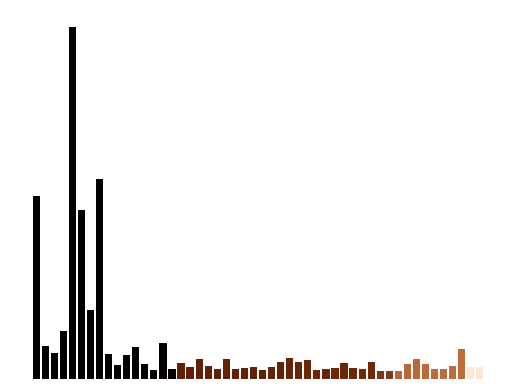

In [6]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [7]:
white = sorted_colours_by_intensity[-1]
emulsion = sorted_colours_by_intensity[-3]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

White value: (255, 230, 213)
Emulsion value: (190, 106, 59)


### Preprocess `emulsion` to get pigment

In [8]:
from nevernegative.layers.balancing.temperature import Temperature

pigment = (emulsion * 255 / white).astype(np.uint8)
temperature = Temperature.infer_temperature(white)

print(f"Pigment value: {tuple(pigment.tolist())}")
print(f"Estimated white temperature: {temperature:.0f}K.")


Pigment value: (190, 117, 70)
Estimated white temperature: 5140K.


(np.float64(-0.5), np.float64(4923.5), np.float64(7377.5), np.float64(-0.5))

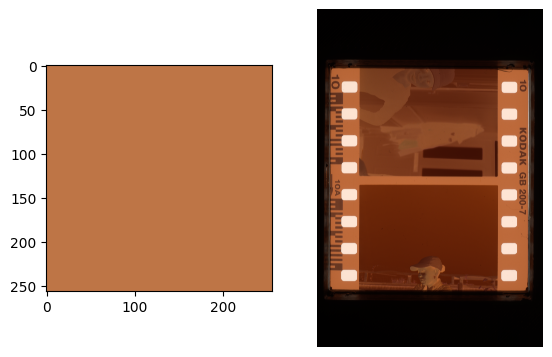

In [9]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

figure, axes = plt.subplots(1, 2)
[pigment_axis, image_axis] = axes.ravel()

pigment_axis.imshow(pigment_image)
image_axis.imshow(image)

plt.axis("off")

## Layers

In [12]:
from pathlib import Path
from nevernegative.layers.utils.resize import Resize
from nevernegative.scanner.simple import SimpleScanner
import matplotlib.pyplot as plt
import torch

In [17]:
images_path = Path("/Users/louismanestar/Library/CloudStorage/GoogleDrive-louis.manestar@gmail.com/My Drive/Film Photos/24-07-24 Home:Brighton Pentax Gold/scans/v1")
output_path = Path("/Users/louismanestar/Library/CloudStorage/GoogleDrive-louis.manestar@gmail.com/My Drive/Film Photos/24-07-24 Home:Brighton Pentax Gold/nevernegative/v1")

glob = "*.NEF"

In [17]:
images_path = Path("/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/images/Brighton")
output_path = Path("/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/images/Brighton/check")

glob = "*.NEF"

### V1: Contrast Stretching

In [ ]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.contrast_stretch import ContrastStretch
from nevernegative.layers.utils.clip import Clip
from nevernegative.layers.balancing.invert import Invert

layers = [
    Invert(),
    ContrastStretch((0.01, 0.99), per_channel=True, mode="mean"),
    Gamma(1.3, channel=2),
    Clip(),
]

### V2: Remove pigment

In [ ]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.grey import Grey
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.saturation import Saturation
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.balancing.invert import Invert
from nevernegative.layers.crop.box import BoxCrop
from nevernegative.layers.crop.hough import HoughCrop
from nevernegative.layers.metrics.pigment_match import PigmentMatch
from nevernegative.layers.utils.blur import Blur
from nevernegative.layers.utils.edge import EdgeDetect
from nevernegative.layers.utils.threshold import Threshold

# (-0.02, -0.06)

layers = [
    # HoughCrop(padding=0, preprocessing_layers=[
    #     Resize(height=800),
    #     PigmentMatch((143, 102, 70), stops=+1, max_stops=+2, ord=3,),
    #     Blur((5, 5)),
    #     EdgeDetect(sigma=1),
    # ]),
    Temperature(temperature=6000),
    RemoveEmulsionPigment(pigment=(190, 117, 70)),
    Invert(),
    Brightness(0.72, channel=0),
    Brightness(0.6, channel=1),
    Brightness(0.49, channel=2),
    Contrast(2.2),
    Brightness(1.4),
    Saturation(1),
]

### V2.1: Slightly Bluer hue (works for Gold, maybe separate?)

In [14]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.saturation import Saturation
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.balancing.invert import Invert

layers = [
    Temperature(temperature=6000),
    RemoveEmulsionPigment(pigment=(190, 117, 70)),
    Invert(),
    Brightness(0.72, channel=0),
    Brightness(0.6, channel=1),
    Brightness(0.55, channel=2),
    Contrast(2.2),
    Brightness(1.4),
    Saturation(1),
]

### V3: Means Matching

In [ ]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.match_means import MatchMeans
from nevernegative.layers.balancing.shift import ShiftBound
from nevernegative.layers.balancing.invert import Invert

layers = [
    Invert(),
    MatchMeans(0, 1),
    MatchMeans(2, 1),
    ShiftBound(0.01, value=0.05),
    Gamma(0.9),
]

### Testing Layers

### Film Image

In [ ]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

processed = scanner.array(
    torch.tensor(image).permute(2, 0, 1).to("mps"),
    plot_path=output_path / "film_image"
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

#### Single Image

(np.float64(-0.5), np.float64(265.5), np.float64(399.5), np.float64(-0.5))

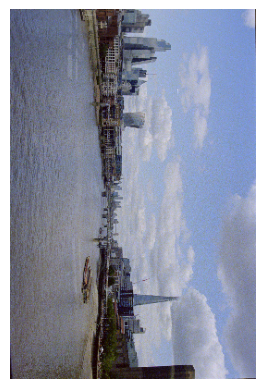

In [18]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

filename = "DSC_2115.NEF"

processed = scanner.file(
    source=images_path / filename,
    destination=output_path / "single_image",
    is_raw=True,
    plot_path="image_location"
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

In [19]:
scanner = SimpleScanner(layers, device="mps")

scanner.glob(
    source=(images_path / glob).as_posix(),
    destination=output_path,
    is_raw=True,
)

Proccesing images: 100%|██████████| 36/36 [03:36<00:00,  6.01s/it]
